In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import ricker
from tqdm.auto import tqdm
import scipy
from time import time
import torch
import torch.fft as fft
import torch.nn.functional as F

In [13]:
velocities = np.load("Density_Test.npy")
nx = 128

In [14]:
def shape_velocity(v, nx):
    v_2 = scipy.ndimage.zoom(v.reshape((51, 51)), nx/51, order=0)
    return v_2 / v_2.max()

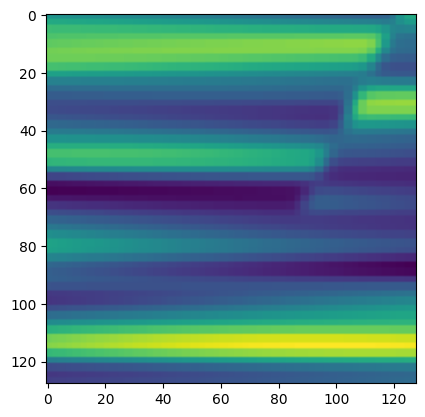

In [15]:
idx = 4
plt.imshow(shape_velocity(velocities[idx], nx))

In [175]:
def init(idx, nx, device="mps"):
    nt  = 256
    isx = 0
    isz = nx // 2
    f0  = 15 * 5
    
    c = 300.0 * shape_velocity(velocities[idx], nx)
    c = torch.tensor(c, device=device, dtype=torch.float32)

    dx = 1.0
    dt = 0.001
    
    shape = (nx, nx)
    zeros = lambda: torch.zeros(shape, device=device, dtype=torch.float32)

    ap    = zeros()
    apnew = zeros()
    apold = zeros()
    ad2px = zeros()
    ad2pz = zeros()

    sp    = zeros()
    spnew = zeros()
    spold = zeros()
    sd2px = zeros()
    sd2pz = zeros()
    
    t = torch.arange(1, nt+1, device=device) * dt
    T0 = 1.0 / (15 * 5)

    tmp = torch.diff(torch.tensor(ricker(dt, T0), device=device, dtype=torch.float32)) * 1e7
    src = torch.zeros(nt, device=device, dtype=torch.float32)
    src[:tmp.numel()] = tmp

    lam = c * T0
    
    x = torch.arange(nx, device=device) * dx
    z = x.clone()

    sigma = 1.5 * dx
    x0, z0 = x[isx-1], z[isz-1]

    xx = x[:, None]
    zz = z[None, :]

    sg = torch.exp(-((xx - x0)**2 + (zz - z0)**2) / sigma**2)
    sg = sg / sg.max()

    return (nt, c, ap, apnew, apold, ad2px, ad2pz, sp, spnew, spold, sd2px, sd2pz, dx, dt, src, sg)

The final solution for our 2D acoustic wave problem after taking into account the finite differences time extrapolation can be written as

$$\begin{equation} p_{j,k}^{n+1} = dt^2c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p){j,k} + dt^2s{j,k}^{n} + 2p_{j,k}^{n} - p_{j,k}^{n-1} \end{equation}$$

In order to compare the above numerical solution, we implement a 5-point finite difference operator to compute spatial derivatives

$$\begin{equation} \partial_t^2 p(x,t) = \frac{-p(x,t+2\mathrm{d}t) + 16p(x,t+\mathrm{d}t) - 30p(x,t) + 16p(x,t-\mathrm{d}t) - p(x,t-2\mathrm{d}t)}{12\mathrm{d}t^2} \end{equation}$$

temporal derivative is done with a 3-point finite difference operator.

In [176]:
kx = 2 * torch.pi * torch.fft.fftfreq(nx, d=dx, device="mps")
kx2 = -(kx**2).reshape(-1, 1)
kz2 = -(kx**2).reshape(1, -1)

@torch.compile
def spectral_step(sp, spold, c, dt, sg, src, it):
    sp_fft = fft.fft2(sp)
    return sp, 2*sp - spold + c**2 * dt**2 * (fft.ifft2(sp_fft * kx2).real + fft.ifft2(sp_fft * kz2).real) + sg * src[it] * dt**2
    
@torch.compile
def fd_step(ap, apold, c, dt, dx, sg, src, it):
    return ap, 2*ap - apold + c**2 * dt**2 * (
            ((-torch.roll(ap, -2, dims=0) + 16 * torch.roll(ap, -1, dims=0) - 30 * ap + 16 * torch.roll(ap,  1, dims=0) - torch.roll(ap,  2, dims=0)) / (12 * dx**2))
            + (( - torch.roll(ap, -2, dims=1) + 16 * torch.roll(ap, -1, dims=1) - 30 * ap + 16 * torch.roll(ap,  1, dims=1) - torch.roll(ap,  2, dims=1)) / (12 * dx**2))
        ) + sg * src[it] * dt**2

In [196]:
def get_traces(idx, nx, device="mps"):
    (nt, c, ap, apnew, apold, ad2px, ad2pz, sp, spnew, spold, sd2px, sd2pz, dx, dt, src, sg) = init(idx, nx, device=device)

    trace_spectral = []
    trace_fd = []
    
    torch.mps.empty_cache()
    t0 = time()
    for it in range(nt):
        spold, sp = spectral_step(sp, spold, c, dt, sg, src, it)
        trace_spectral.append(sp[0].detach().cpu())
    time_s = time() - t0
    
    torch.mps.empty_cache()
    t0 = time()

    for it in range(nt):
        apold, ap = fd_step(ap, apold, c, dt, dx, sg, src, it)
        trace_fd.append(ap[0].detach().cpu())

    time_fd = time() - t0

    return (
        torch.stack(trace_spectral),
        time_s,
        torch.stack(trace_fd),
        time_fd,
        nt, dt, c.cpu(), nx, dx
    )

In [178]:
def display_traces(idx, nx):
    trace_spectral, time_s, trace_fd, time_fd, nt, dt, c, nx, dx = get_traces(idx, nx)
    fig, ax = plt.subplots(1, 4, figsize=(25, 6))
    f = ax[0].imshow(c, cmap="hot")
    plt.colorbar(f)
    ax[0].set_title("Velocity field")
    f = ax[1].imshow(trace_fd, aspect='auto', cmap='seismic')
    ax[1].set_title(f"Finite differences, {time_fd:.3f}s, mean abs: {torch.mean(torch.abs(trace_fd)):.4e}")
    plt.colorbar(f)
    f = ax[2].imshow(trace_spectral, aspect='auto', cmap='seismic')
    ax[2].set_title(f"Pseudospectral, {time_s:.3f}s, mean abs: {torch.mean(torch.abs(trace_spectral)):.4e}")
    plt.colorbar(f)
    f = ax[3].imshow(np.abs(trace_fd-trace_spectral), aspect='auto', cmap='seismic')
    ax[3].set_title(f"Absolute difference, mean abs: {torch.mean(torch.abs(trace_fd-trace_spectral)):.4e}")
    plt.colorbar(f)
    plt.suptitle(f"Example of propagation, index: {idx}, t: {nt*dt:.3f}s, dt: {dt:.3f}s, dx: {dx:.3f}m")
    plt.tight_layout()
    plt.show()

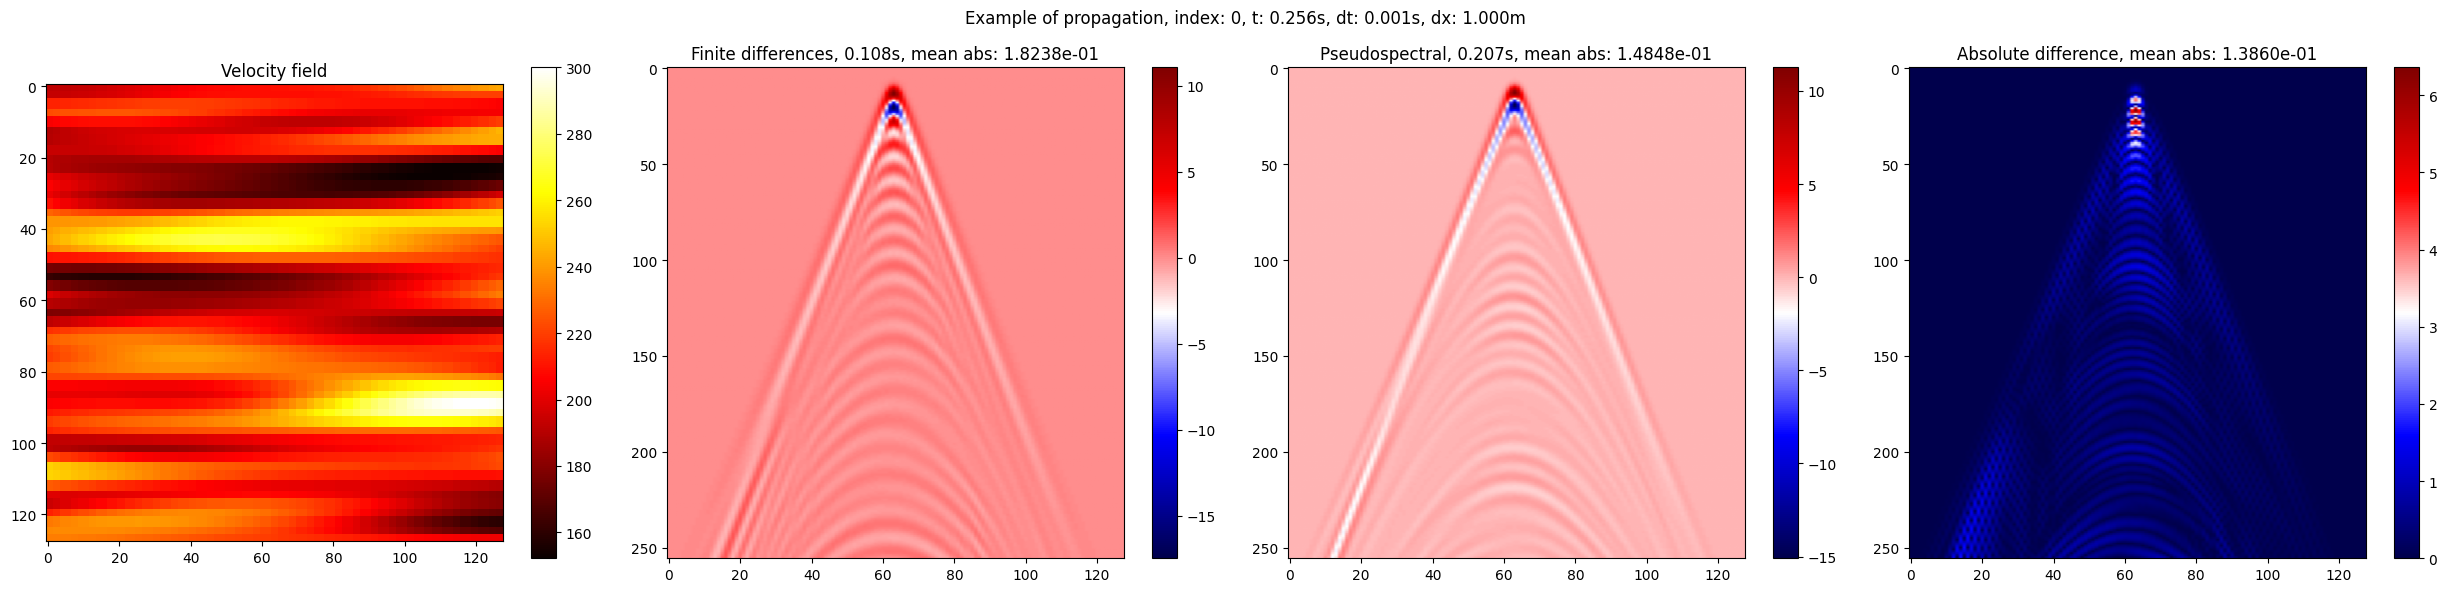

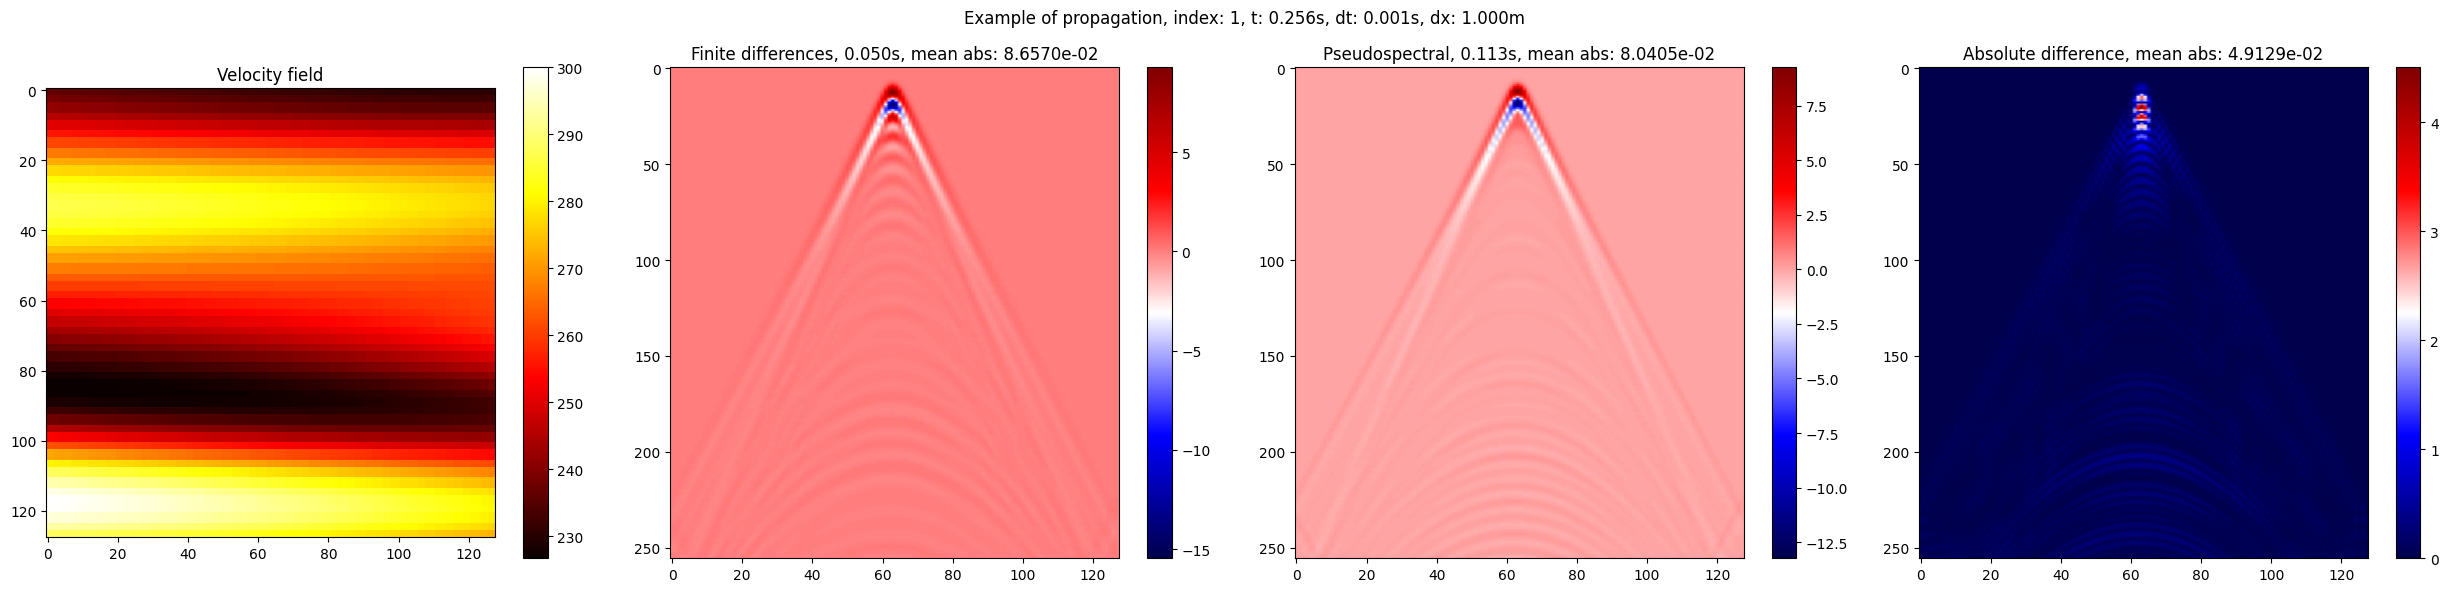

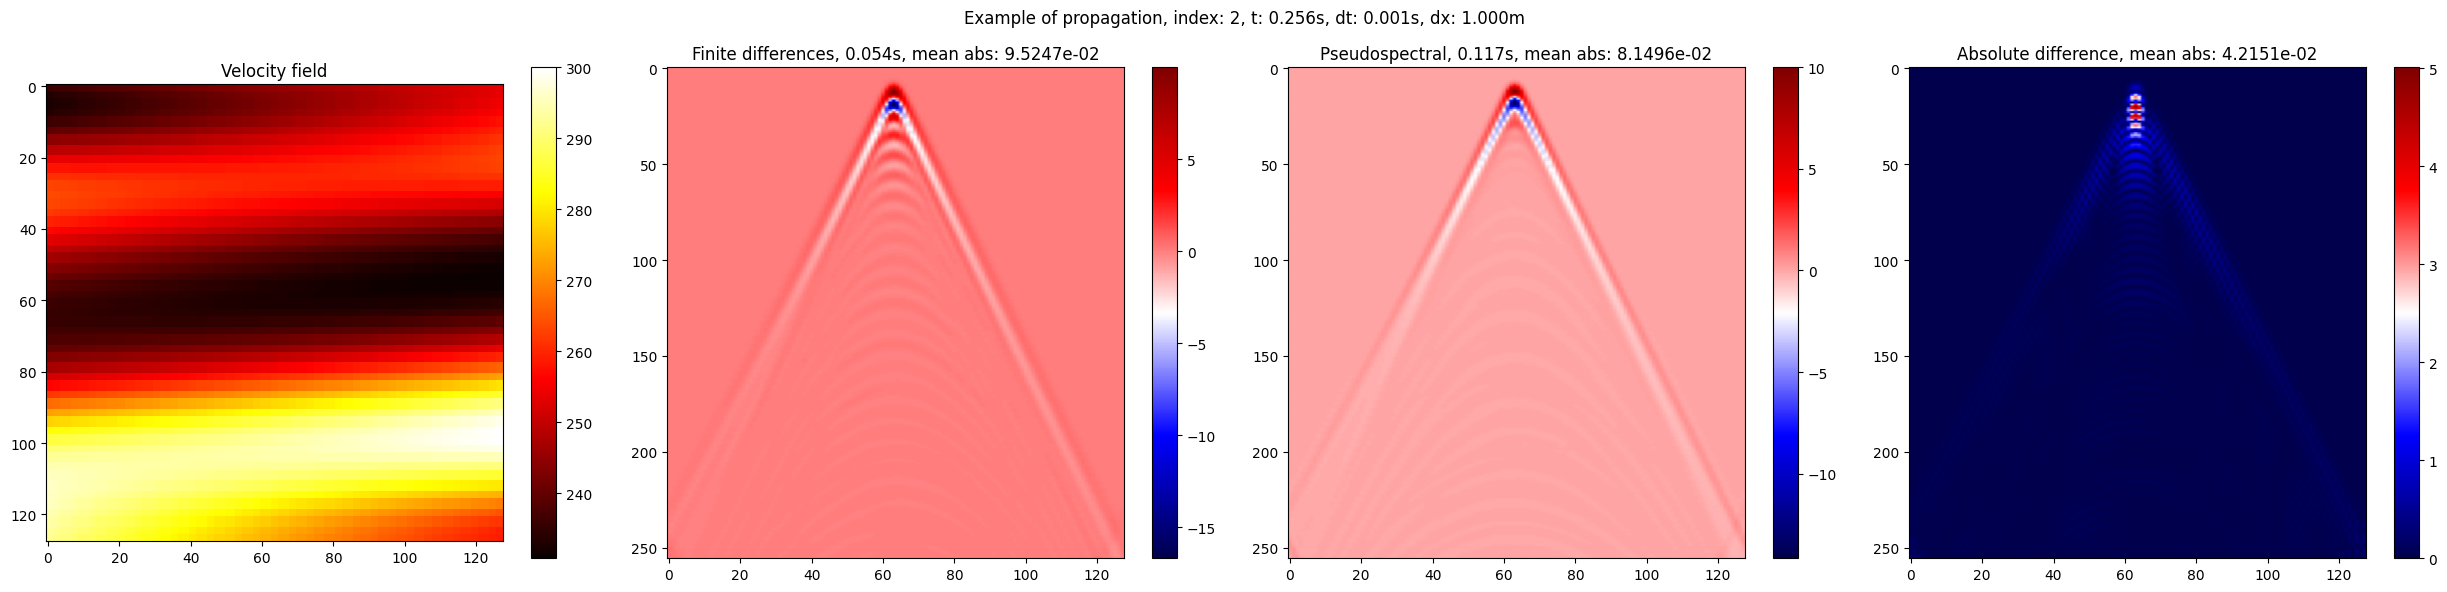

In [179]:
for idx in range(3):
    display_traces(idx, 128)

In [180]:
velocities = np.load("Density_Test.npy")
nx = 128

In [181]:
y, x = [], []
time_s_total = 0
time_fd_total = 0
cs = []
for idx in tqdm(range(velocities.shape[0])):
    trace_spectral, time_s, trace_fd, time_fd, nt, dt, c, nx, dx = get_traces(idx, nx)
    y.append(trace_spectral.clone())
    x.append(trace_fd.clone())
    time_s_total += time_s
    time_fd_total += time_fd
    cs.append(c.clone())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [182]:
torch.save(torch.stack(y), "dataset/y_test.pt")
torch.save(torch.stack(x), "dataset/x_test.pt")
torch.save(torch.stack(cs), "dataset/c_test.pt")
print("Pseudospectral time, average:", time_s_total/velocities.shape[0])
print("Finite Differences time, average:", time_fd_total/velocities.shape[0])

Pseudospectral time, average: 0.09657825565338135
Finite Differences time, average: 0.05183129954338074


In [184]:
velocities = np.load("Density_Train.npy")
nx = 128

In [185]:
velocities.shape

(27000, 2601)

In [200]:
y, x = [], []
time_s_total = 0
time_fd_total = 0
cs = []
for idx in tqdm(range(10000, velocities.shape[0])):
    trace_spectral, time_s, trace_fd, time_fd, nt, dt, c, nx, dx = get_traces(idx, nx)
    y.append(trace_spectral.clone())
    x.append(trace_fd.clone())
    time_s_total += time_s
    time_fd_total += time_fd
    cs.append(c.clone())

  0%|          | 0/17000 [00:00<?, ?it/s]

In [201]:
torch.save(torch.stack(y), "dataset/y_train_2.pt")
torch.save(torch.stack(x), "dataset/x_train_2.pt")
torch.save(torch.stack(cs), "dataset/c_train_2.pt")
print("Pseudospectral time, average:", time_s_total/velocities.shape[0])
print("Finite Differences time, average:", time_fd_total/velocities.shape[0])

Pseudospectral time, average: 0.07027947584788005
Finite Differences time, average: 0.03509579300880432


list